In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
print (tf.__version__)

1.13.1


# Fundamentos de TensorFlow

**Expresiones**
- Las expresiones son construidas en términos de **variables** (para los parémetros, como $\theta$) y **placeholders** (para los datos)

- Cuando definimos las expresiones **construimos su grafo simbólico**, pero **no son evaluadas**

- Las expresiones sólo son evaluadas **dentro de una sesión**

- El proceso de **optimización** trata de encontrar valores de las **variables** que minimizan una cierta expresión. 


**Parámetros**
- Las **variables** tienen un tamaño fijo, contienen los parámetros de un modelos, que luego pueden ser salvados o restaurados.

- Las **variables** pueden tener un valor constante, pero normalmente se inicializan con algún valor aleatorio o determinado, y su contenido va variando durante el proceso de optimización.

**Datos**
- Los **placeholders** pueden ser matrices (tensores) con un número fijo de columnas, pero variable de filas, para poder evaluar las expresiones con distintos datasets.

- Los **placeholders** no tienen valores iniciales, y hay que alimentarlos directamente con los datos



**Gradientes**

- TensorFlow calcula automáticamente los gradientes de las expresiones, que los obtiene simbólicamente. Normalmente los gradientes se calculan **respecto a los parámetros** (_placeholders_)

## TensorFlow: cálculo simbólico para ML

fíjate cómo en TF se define un grafo (simbólico) y luego se le inyectan valores para evaluarlo


In [4]:
tf.reset_default_graph()
x = tf.Variable(initial_value=tf.random_normal([1]), name="x", dtype=tf.float32)
y = tf.Variable(initial_value=tf.random_normal([1]), name="y", dtype=tf.float32)
f = x**2+y**2
f

Instructions for updating:
Colocations handled automatically by placer.


<tf.Tensor 'add:0' shape=(1,) dtype=float32>

In [5]:
dx = tf.gradients(f, x)
dy = tf.gradients(f, y)


In [7]:
val_x, val_y = 5, 2
with tf.Session() as sess:
    val_f, val_dx, val_dy = sess.run([f, dx, dy], feed_dict={x: [val_x], y:[val_y]})
print(" f(%d,%d) = %d"%(val_x, val_y, val_f))
print("dx(%d,%d) = %d"%(val_x, val_y, val_dx[0]))
print("dy(%d,%d) = %d"%(val_x, val_y, val_dy[0]))

 f(5,2) = 29
dx(5,2) = 10
dy(5,2) = 4


In [8]:
!rm -rf tmp
with tf.Session() as sess:
    writer = tf.summary.FileWriter("tmp", sess.graph)


run

     tensorboard --logdir tmp
    
from the command line and open [localhost:6006](http://localhost:6006) to inspect the **computational graph** represeting the previous expression

## Single Layer Perceptron

$$\hat{y} = \text{sigmoid}(\mathbf{W}_2 \cdot \tanh(\mathbf{x^T} \cdot \mathbf{W}_1 + \mathbf{b}_1) + b_2)$$

$$J(\mathbf{b}_1, b_2, \mathbf{W}_1, \mathbf{W}_2) = \frac{1}{m}\sum_{i=0}^{m-1} (\hat{y}-y)^2 $$


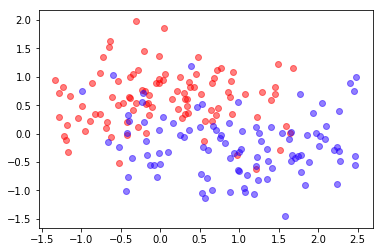

In [9]:
from sklearn.datasets import make_moons
import mlutils
X,y = make_moons(200,noise=.4)
mlutils.plot_2Ddata(X,y)

### Input parameters

In [10]:
input_units  = 2
h_units      = 5
output_units = 1

### Computational graph

In [12]:
def get_graph():
    tf.reset_default_graph()

    # symbolic vars for model parameters
    tW1 = tf.Variable(initial_value=tf.random_uniform([input_units, h_units], 
                                                      dtype=tf.float64), name="W1", dtype=tf.float64)
    tb1 = tf.Variable(initial_value=tf.random_uniform([h_units], 
                                                      dtype=tf.float64), name="b1", dtype=tf.float64)
    tW2 = tf.Variable(initial_value=tf.random_uniform([h_units, output_units], 
                                                      dtype=tf.float64), name="W2", dtype=tf.float64)
    tb2 = tf.Variable(initial_value=tf.random_uniform([output_units], 
                                                      dtype=tf.float64), name="b2", dtype=tf.float64)

    # symbolic vars for data
    tX = tf.placeholder(name="X", dtype=tf.float64, shape = (None, input_units))
    ty = tf.placeholder(name="y", dtype=tf.float64, shape = (None, output_units))


    y_hat = tf.sigmoid(tf.matmul(tf.tanh(tf.matmul(tX,tW1)+tb1), tW2) + tb2)
    loss = tf.reduce_mean(tf.pow((y_hat - ty),2))             

    init = tf.global_variables_initializer()

    optimizer_step = tf.train.GradientDescentOptimizer(.5).minimize(loss)

    
    print(tW1.shape)
    print(tW2.shape)
    print(tb1.shape)
    print(tb2.shape)
    
    return tW1, tb1, tW2, tb2, tX, ty, y_hat, loss, init, optimizer_step

In [13]:
tW1, tb1, tW2, tb2, tX, ty, y_hat, loss, init,optimizer_step = get_graph()

(2, 5)
(5, 1)
(5,)
(1,)


### Optimization

- observe how data is shuffled at every epoch

In [15]:
loss_hist = []
n_epochs   = 3000

with tf.Session() as sess:
    sess.run(init)
    
    for i in mlutils.pbar()(range(1,n_epochs)):
        # parameter update
        idxs = np.random.permutation(len(X))
        _, _loss = sess.run([optimizer_step, loss], feed_dict={tX: X[idxs], ty: y[idxs].reshape(-1,1)})
        loss_hist.append(_loss)
        
    val_W1, val_W2, val_b1, val_b2 = sess.run([tW1, tW2, tb1, tb2])

100% (2999 of 2999) |####################| Elapsed Time: 0:00:01 Time:  0:00:01


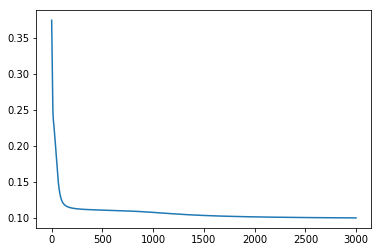

In [16]:
plt.plot(loss_hist)

### Prediction

In [17]:
def predict(X):
    with tf.Session() as sess:
        preds = sess.run(y_hat, feed_dict={tX: X,  
                                           tW1: val_W1, tW2: val_W2, tb1: val_b1, tb2: val_b2})
    return (preds[:,0]>.5).astype(int)

(0.50955, 0.49045)

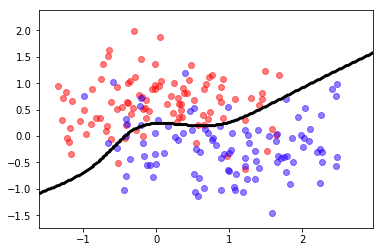

In [18]:
mlutils.plot_2Ddata_with_boundary(predict, X, y)


### Batch optimization

observe how:

- training data is partitioned in batches
- the optimization step is called several times during each epoch
- the number of epochs is reduces proportionally
- the number of calls to the optimization step is the same
- data is shuffled at every epoch
- the process is more stochastic
- at each epoch the only one **loss** metric is averaged over the loss obtained by all batches. 

you will appreciate the advantage of batch optimization in the corresponding lab

In [19]:
tW1, tb1, tW2, tb2, tX, ty, y_hat, loss, init,optimizer_step = get_graph()

(2, 5)
(5, 1)
(5,)
(1,)


In [20]:
batch_size = 10
num_examples = len(X)
bloss_hist = []
c=0
with tf.Session() as sess:
    sess.run(init)
    for epoch in mlutils.pbar()(range(1,n_epochs*batch_size//num_examples+1)):
        idxs = np.random.permutation(len(X))
        eloss = []
        for iteration in range(num_examples // batch_size):
            X_batch = X[idxs][iteration*batch_size:iteration*batch_size+batch_size]
            y_batch = y[idxs][iteration*batch_size:iteration*batch_size+batch_size]
            _, _loss = sess.run([optimizer_step, loss], feed_dict={tX: X_batch, ty: y_batch.reshape(-1,1)})
            eloss += [_loss]
            c+=1
        bloss_hist += [np.mean(eloss)]
       

100% (150 of 150) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


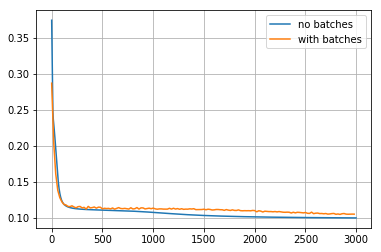

In [21]:
plt.plot(loss_hist, label="no batches")
plt.plot(np.arange(len(bloss_hist))*num_examples // batch_size, bloss_hist, label="with batches")
plt.legend();
plt.grid();

(0.50955, 0.49045)

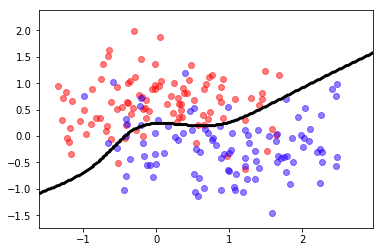

In [22]:
mlutils.plot_2Ddata_with_boundary(predict, X, y)